# Multi-level (and Multi-Step) Hierarchical Classification

In [3]:
import re
import pandas as pd
import nltk
from collections import Counter
import numpy as np
import scipy as sp
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader
# from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
# from googletrans import Translator
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer


## Useful Functions

### Reading

In [4]:
MIN_DF = 50
RANDOM_STATE = 42


def read_data(path, deli):
    df = pd.read_csv(path, delimiter=deli)
    return df


def sample_data(df, fraction):
    stratified_sample = df.groupby('puor_ds_level1_new',group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=RANDOM_STATE))
    return stratified_sample

def filtering_level1(df):
    df = df.loc[df["puor_ds_level1_new"] != "OUT OF SCOPE"]
    return df


def drop_na_records(df):
    # how='any' if at least one element is null in the row, drop the entire row
    return df.dropna(how="any", axis=0)

def clean(text):
    text = text.lower()
    return text

#translator = Translator()
#def translate2en(tokens):
#        translated_tokens = [translator.translate(t, src="auto", dest="en").text for t in tokens]
#        return translated_tokens             
             


### Features

In [ ]:
def sklearn_split(text):
    # return re.findall(r'(?u)\b\w\w+\b', text) # matches scikit-learn's TfidfVectorizer class to tokenize text
    # return re.findall(r'(?u)\b[a-zA-Z]\w+\b', text) # starting with a letter
    # return re.findall(r'(?u)[A-Za-z0-9][A-Za-z]+', text)
    return re.findall(r"(?u)[A-Za-z0-9][A-Za-z][A-Za-z]+", text)
    # (?u) turns on Unicode matching and not only ASCII characters
    # \b means starting and ending --> Matches only words, not punctuation

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# stemmatization
ps = PorterStemmer()
vocabulary = {}

# lemmatization qith Wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()


def text_processing(word_tokens, train=True, bigrams=False, range_grams=None, root_word_type='stemmatization'):
    """Generates tokens, implements stemmatization or lemmatization, revomes stopwords and updates the vocabulary
    Args
        word_tokens::string, words to be tokenized
        train::boolean,  if True (default) updates the vocabulary only for the training set. This is done to prevent data leakage
        bigrams::boolean, if False (default) generates unigrams, if True generates bigrams
        range_grams::string, if "(1,2)" generates unigrams and bigrams, if "(2,2)" gemerates only bigrams, but
                                words with only onegram are retained
                                e.g. transportation cost for UK --> [transport cost, cost UK]
                                e.g. 1213 transport --> [transport]
    Return
        text_proc_ret::list, list of word tokens
        
    """
    if root_word_type=='stemmatization':
        text_proc = [ps.stem(w) for w in word_tokens if not w in stop_words]
    elif root_word_type=='lemmatization':
        text_proc = [lemmatizer.lemmatize(word, pos="v") for word in word_tokens]  

    if bigrams == True and range_grams == "(1,2)":
        text_proc_ret = text_proc + [
            f"{text_proc[i]} {text_proc[i+1]}" for i in range(len(text_proc) - 1)
        ]

    if bigrams == True and range_grams == "(2,2)":
        if len(text_proc) == 1:
            text_proc_ret = text_proc.copy()
        else:
            text_proc_ret = [f"{text_proc[i]} {text_proc[i+1]}" for i in range(len(text_proc) - 1)]

    if train:
        for w in text_proc_ret:
            if w in vocabulary:
                vocabulary[w] += 1
            else:
                vocabulary[w] = 1
    return text_proc_ret


def encoding_categorical_features(X_train, X_test, min_frq, drp="first", handle_uknwn="ignore"):
    """One hot encoding
    Args:
        X_train::vector or pandas Series, the X feature of the training set to be encoded
        X_test::vector or pandas Series, the X feature the test test to be encoded
        min_frq::int, minminum frequency for a value of the category to be retained
        drp::string, drop first value because it can be inferred from the others
        handle_uknw::string, ignore new values when are encountered i.e. in the test set
    Return
        encodings::tuple, containing the encoding of the training set and test, and a mapping of categories for the training set
    """
    enc = OneHotEncoder(drop=drp, handle_unknown=handle_uknwn, min_frequency=min_frq)
    X_train_enc = enc.fit_transform(X_train)
    cats = enc.categories_[0]
    map_id_to_cat = {v: k for v, k in enumerate(cats)}
    print(f"Number of features:{len(cats)}")
    print(f"First five features:{cats[:5]}")

    if min_frq != None:
        cats_infrequent = enc.infrequent_categories_[0]
        cats_infrequent_set = set(cats_infrequent)
        cats_retained = [c for c in cats if c not in cats_infrequent_set]
        print(f"Infrequent categories: {len(cats_infrequent)}")
        print(f"First five entries: {cats_infrequent[:5]}")
        print(
            f"Retained features (# Features - Infrequent features): {len(cats)-len(enc.infrequent_categories_[0])}"
        )
        map_id_to_cat = {v: k for v, k in enumerate(cats_retained)}

    X_test_enc = enc.transform(X_test)
    encodings = (X_train_enc, X_test_enc, map_id_to_cat)
    return encodings

# Functions for Word2Vec
# Loading pre-trained embeddings from Google
google_news = gensim.downloader.load('word2vec-google-news-300')

def remove_stop_word_to_tokens(row):
    return [w for w in row if w not in stop_words]


def remove_words_not_in_embeddings(row, embds):
    return [w for w in row if w in embds.keys()]


def generate_word_vector_features(tokenized_texts, embds):
    docs = []
    for tokens in tokenized_texts:
        embeddings_row = []
        for word in tokens:
            if len(tokens)==0:
                embeddings_row.append(np.zeros(300))
            embeddings_row.append(embds[word])
            matrix_row = np.sum(np.vstack(embeddings_row), axis=0)
        docs.append(matrix_row)
    return np.vstack(docs)    


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riccardoricci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\riccardoricci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\riccardoricci\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Modeling

In [ ]:
def model(classifier, X_tr, y_tr, X_ts, y_ts, rnd_state=RANDOM_STATE, cls_wght=None, max_feat=None):
    """fitting a machine learning model, provides accuracies at the class level and predicts values for the test set
    Args
        classifier, type of classifier e.g. DecisionTreeClassifier
        X_tr, training set
        y_tr, target variable of training set i.e. level1, or level2, or level3 or level4 category
        X_ts, test set
        y_ts, target variable of test set
        rnd_state::int, random state to have reproducible results
        cls_wght::dict or string, class weights to balance the model e.g. balanced
    Return
        modeling::tuple, cotaining the model, the prediction, and the ground-truth values


    """
    mdl = classifier(random_state=rnd_state, class_weight=cls_wght, max_features=max_feat)  # weights, #balanced
    mdl.fit(X_tr, y_tr)
    print("Accuracy on training set: {:.3f}".format(mdl.score(X_tr, y_tr)))
    print("Accuracy on test set: {:.3f}".format(mdl.score(X_ts, y_ts)))
    dummy_cls = DummyClassifier(strategy="stratified").fit(X_tr, y_tr)
    print("Accuracy on test set by a DUMMY CLASSIFIER: {:.3f}".format(dummy_cls.score(X_ts, y_ts)))
    y_preds = mdl.predict(X_ts)  # X_train
    y_trues = y_ts  # train.puor_ds_level1_new #
    print("Classification Report for Test Set")
    print(classification_report(y_true=y_trues, y_pred=y_preds))
    print("Classification Report for Training Set")
    print(classification_report(y_true=y_tr, y_pred=mdl.predict(X_tr)))
    modeling = (mdl, y_preds, y_trues)
    return modeling


def integrating_prev_lev_predict_next_lev(X_train, X_test, level, model):
    """Integrates prediction of level i as a new feature for the next training predicting the level i+1 category
    Args
        X_train,
        X_test,
        level::string, category level e.g. puor_ds_level2_new
        model, classifier
    Return
        train_test_new::tuple

    """
    X_train_next_lvl_pred = model.predict(X_train).reshape(-1, 1)
    X_test_next_lvl = np.array(test[level]).reshape(-1, 1)
    X_train_next_lvl_pred_one, X_test_next_lvl_one, map = encoding_categorical_features(
        X_train=X_train_next_lvl_pred, X_test=X_test_next_lvl, min_frq=None
    )
    X_train_new = sp.sparse.hstack([X_train, X_train_next_lvl_pred_one])
    X_test_new = sp.sparse.hstack([X_test, X_test_next_lvl_one])
    train_test_new = (X_train_new, X_test_new)
    return train_test_new

## Reading and exploring data

In [ ]:
train = read_data(
                    path=r"C:\Users\riccardoricci\Documents\data_MADS_CAPSTONE\training_data_2025-03-03.csv",
                  #path="data/training_data_2025-03-03.csv", 
                  deli="|")
train = drop_na_records(train)
train = filtering_level1(train)
print(len(train))

2074804


In [ ]:
train['puor_ds_level1_new'].value_counts(normalize=True)

SUPPLY CHAIN             0.571922
TECHNICAL PROCUREMENT    0.247748
GENERAL PROCUREMENT      0.180330
Name: puor_ds_level1_new, dtype: float64

In [ ]:
# train = sample_data(train, 0.15)
test = read_data(
                #path="data/test_set_2025-03-03.csv",
                path=r"C:\Users\riccardoricci\Documents\data_MADS_CAPSTONE\test_set_2025-03-03.csv",
                deli="|")
test = drop_na_records(test)
test = filtering_level1(test)

In [ ]:
len(train)

2074804

In [ ]:
train['puor_ds_level1_new'].value_counts(normalize=True)

SUPPLY CHAIN             0.571922
TECHNICAL PROCUREMENT    0.247748
GENERAL PROCUREMENT      0.180330
Name: puor_ds_level1_new, dtype: float64

In [ ]:
print(f"Training set has {train.shape[0]} rows and {train.shape[1]} columns")
print(f"Test set has {test.shape[0]} rows and {test.shape[1]} columns")

Training set has 2074804 rows and 11 columns
Test set has 61282 rows and 11 columns


In [ ]:
train.sample(5)

,puor_id_order_line,puor_id_lfa1_supplier,puor_id_t001_company,puor_id_prgp_purchasing_group,puor_id_pror_purchasing_org,puor_ds_po_description_translated,puor_ds_level1_new,puor_ds_level2_new,puor_ds_level3_new,puor_ds_level4_new,puor_cd_mat_group
222555,SAPECCFE3_7008020374_10,SAPECCFE3_0000165068,SAPECCFE3_IN10,SAPECCFE3_B09,SAPECCFE3_IN05,DONALDSON OVAL FILTER 660H 2625112/E,TECHNICAL PROCUREMENT,AUTOMATION & MRO,"TECHNICAL MATERIALS, PPE & CLOTHES",Filters,MR0162
1888621,SAPECCFE3_8210445368_520,SAPECCFE3_0000121489,SAPECCFE3_BR10,SAPECCFE3_Y01,SAPECCFE3_BR06,Transport /Guarulhos,SUPPLY CHAIN,PRIMARY TRANSPORTS,ROAD TRANSPORT,Road Transportation,ZZ0304
2647819,SAPECCFE3_8210282455_10,SAPECCFE3_0000167330,SAPECCFE3_BR10,SAPECCFE3_Y01,SAPECCFE3_BR06,Transport /RIODASOSTR,SUPPLY CHAIN,SECONDARY FREIGHT,DISTRIBUTION,Distribution to Customers and Returned Goods f...,ZZ9450
2536752,SAPECCFIP_5000181883_10,SAPECCFIP_0000473359,SAPECCFIP_DE30,SAPECCFIP_BUF,SAPECCFIP_1600,Nu_nutella_epal_blende_FED/7286,GENERAL PROCUREMENT,SALES SERVICES,POS MATERIAL,POS material Development & Sampling,ZZ9345
1732013,SAPECCFE3_6100156603_4,SAPECCFE3_0000031341,SAPECCFE3_IT35,SAPECCFE3_1B4,SAPECCFE3_ITL9,CRISTAL BIC BALLPOINT PEN 1MM BLACK,GENERAL PROCUREMENT,WORKPLACE SERVICES,OFFICE SUPPLIES AND SERVICES,Office supplies,ZZ2201


In [ ]:
for lvl in range(1,5):
    print(f"TRAIN: # categories at Level {str(lvl)}:",len(train[f"puor_ds_level{str(lvl)}_new"].drop_duplicates()))
    print(f"TEST: # categories at Level {str(lvl)}:",len(test[f"puor_ds_level{str(lvl)}_new"].drop_duplicates()))

TRAIN: # categories at Level 1: 3
TEST: # categories at Level 1: 3
TRAIN: # categories at Level 2: 20
TEST: # categories at Level 2: 19
TRAIN: # categories at Level 3: 105
TEST: # categories at Level 3: 85
TRAIN: # categories at Level 4: 604
TEST: # categories at Level 4: 426


In [ ]:
train["puor_ds_level1_new"].value_counts()

SUPPLY CHAIN             1186627
TECHNICAL PROCUREMENT     514028
GENERAL PROCUREMENT       374149
Name: puor_ds_level1_new, dtype: int64

In [ ]:
test["puor_ds_level1_new"].value_counts()

GENERAL PROCUREMENT      33866
TECHNICAL PROCUREMENT    27005
SUPPLY CHAIN               411
Name: puor_ds_level1_new, dtype: int64

SUPPLY CHAIN is the most frequent category, but this is the least represented in the test set

**Training and test datasets are not balanced with respect to the categories**. 


In [ ]:
train[["puor_ds_level1_new","puor_ds_level2_new"]].value_counts()

puor_ds_level1_new     puor_ds_level2_new                    
SUPPLY CHAIN           PRIMARY TRANSPORTS                        897923
TECHNICAL PROCUREMENT  AUTOMATION & MRO                          445927
SUPPLY CHAIN           SECONDARY FREIGHT                         227596
GENERAL PROCUREMENT    SALES SERVICES                            159012
                       WORKPLACE SERVICES                         81402
TECHNICAL PROCUREMENT  INFRASTRUCTURE & INDUSTRIAL                54140
GENERAL PROCUREMENT    MARKETING SERVICES                         44715
SUPPLY CHAIN           CUSTOM BROKERAGE & FORWARDING AGENCIES     39657
GENERAL PROCUREMENT    IT - INFORMATION TECHNOLOGY                26302
                       PEOPLE SERVICES                            25706
SUPPLY CHAIN           WAREHOUSING                                19288
GENERAL PROCUREMENT    MOBILITY                                   17510
                       PROFESSIONAL SERVICES                      16125
TE

In [ ]:
test[["puor_ds_level1_new","puor_ds_level2_new"]].value_counts()

puor_ds_level1_new     puor_ds_level2_new                    
GENERAL PROCUREMENT    MARKETING SERVICES                        14748
TECHNICAL PROCUREMENT  AUTOMATION & MRO                          13038
GENERAL PROCUREMENT    WORKPLACE SERVICES                        10223
TECHNICAL PROCUREMENT  INFRASTRUCTURE & INDUSTRIAL                9292
                       PROCESS EQUIPMENT                          4530
GENERAL PROCUREMENT    PEOPLE SERVICES                            4039
                       SALES SERVICES                             2740
                       MOBILITY                                   1439
                       PROFESSIONAL SERVICES                       415
                       IT - INFORMATION TECHNOLOGY                 246
TECHNICAL PROCUREMENT  ENERGY                                      145
SUPPLY CHAIN           CUSTOM BROKERAGE & FORWARDING AGENCIES      117
                       PRIMARY TRANSPORTS                           87
               

In [ ]:
train[["puor_ds_level1_new","puor_ds_level2_new","puor_ds_level3_new"]].value_counts().head(10)

puor_ds_level1_new     puor_ds_level2_new                      puor_ds_level3_new                                       
SUPPLY CHAIN           PRIMARY TRANSPORTS                      ROAD TRANSPORT                                               872821
TECHNICAL PROCUREMENT  AUTOMATION & MRO                        TECHNICAL MATERIALS, PPE & CLOTHES                           383511
SUPPLY CHAIN           SECONDARY FREIGHT                       DISTRIBUTION                                                 227596
GENERAL PROCUREMENT    SALES SERVICES                          POS MATERIAL                                                 124574
TECHNICAL PROCUREMENT  AUTOMATION & MRO                        MAINTENANCE SERVICES                                          59191
GENERAL PROCUREMENT    WORKPLACE SERVICES                      OFFICE SUPPLIES AND SERVICES                                  51459
SUPPLY CHAIN           CUSTOM BROKERAGE & FORWARDING AGENCIES  FREIGHT FORWARDING AGENCIES   

In [ ]:
test[["puor_ds_level1_new","puor_ds_level2_new","puor_ds_level3_new"]].value_counts().head(10)

puor_ds_level1_new     puor_ds_level2_new           puor_ds_level3_new                                       
GENERAL PROCUREMENT    MARKETING SERVICES           CREATIVE DESIGN                                              10975
TECHNICAL PROCUREMENT  AUTOMATION & MRO             TECHNICAL MATERIALS, PPE & CLOTHES                            8932
GENERAL PROCUREMENT    WORKPLACE SERVICES           OFFICE SUPPLIES AND SERVICES                                  6884
TECHNICAL PROCUREMENT  INFRASTRUCTURE & INDUSTRIAL  FACILITY MANAGEMENT SOFTSERVICES FOR INDUSTRIAL LOCATIONS     3290
GENERAL PROCUREMENT    PEOPLE SERVICES              TRAINING                                                      2524
TECHNICAL PROCUREMENT  INFRASTRUCTURE & INDUSTRIAL  LABORATORY EQUIPMENT AND SERVICES                             2321
                       AUTOMATION & MRO             INDUSTRIAL AUTOMATION AND ROBOTICS                            2192
                                                    MAINT

In [ ]:
train[["puor_ds_level1_new","puor_ds_level2_new","puor_ds_level3_new","puor_ds_level4_new"]].value_counts().head(10)

puor_ds_level1_new     puor_ds_level2_new  puor_ds_level3_new                  puor_ds_level4_new                                         
SUPPLY CHAIN           PRIMARY TRANSPORTS  ROAD TRANSPORT                      Road Transportation                                            694847
                       SECONDARY FREIGHT   DISTRIBUTION                        Distribution to Customers and Returned Goods from Customers    227407
GENERAL PROCUREMENT    SALES SERVICES      POS MATERIAL                        POS materials Storage and Logistic                              84447
SUPPLY CHAIN           PRIMARY TRANSPORTS  ROAD TRANSPORT                      Road Transportation Finished Products Export Costs              63115
TECHNICAL PROCUREMENT  AUTOMATION & MRO    MAINTENANCE SERVICES                OPX - Ordinary Maintenance                                      57964
                                           TECHNICAL MATERIALS, PPE & CLOTHES  Other Materials Immediate Use for Mai

In [ ]:
test[["puor_ds_level1_new","puor_ds_level2_new","puor_ds_level3_new","puor_ds_level4_new"]].value_counts().head(10)

puor_ds_level1_new     puor_ds_level2_new           puor_ds_level3_new                                         puor_ds_level4_new                                          
GENERAL PROCUREMENT    MARKETING SERVICES           CREATIVE DESIGN                                            Packaging & POS - Creative Concept                              7186
                       WORKPLACE SERVICES           OFFICE SUPPLIES AND SERVICES                               Office supplies                                                 4053
TECHNICAL PROCUREMENT  AUTOMATION & MRO             TECHNICAL MATERIALS, PPE & CLOTHES                         Other Spare parts (not codified, catalogues items)              2958
GENERAL PROCUREMENT    PEOPLE SERVICES              TRAINING                                                   Training Design & Cost of Personal                              2524
                       MARKETING SERVICES           CREATIVE DESIGN                                         

### Exploring Features

In [ ]:
train["puor_ds_po_description_translated"].sample(5)

1673811                         17950_10.10.2024
1611314         EMT STRAP 3/4", 1HOLE CI1306 T&B
1169985      DOO. CANN.3/8 X 10MM 1231017 LEGRIS
2349564                    514-FREIGHT FORWARDER
2543784    Flowers Birthday Mr. Nolte (Customer)
Name: puor_ds_po_description_translated, dtype: object

## Feature Engineering

### PO Text

TF-IDF Weighting

In [ ]:
# stemmatization
train["puor_ds_po_description_translated_token_sklearn_stem"] = (
    train["puor_ds_po_description_translated"]
    .apply(clean)
    .apply(sklearn_split)
    .apply(text_processing, bigrams=True, range_grams="(1,2)", root_word_type='stemmatization')
)

test["puor_ds_po_description_translated_token_sklearn_stem"] = (
    test["puor_ds_po_description_translated"]
    .apply(clean)
    .apply(sklearn_split)
    .apply(text_processing, train=False, bigrams=True, range_grams="(1,2)", root_word_type='stemmatization')
)

In [ ]:
# lemmatization
train["puor_ds_po_description_translated_token_sklearn_lem"] = (
    train["puor_ds_po_description_translated"]
    .apply(clean)
    .apply(sklearn_split)
    .apply(text_processing, bigrams=True, range_grams="(1,2)", root_word_type='lemmatization')
)

test["puor_ds_po_description_translated_token_sklearn_lem"] = (
    test["puor_ds_po_description_translated"]
    .apply(clean)
    .apply(sklearn_split)
    .apply(text_processing, train=False, bigrams=True, range_grams="(1,2)", root_word_type='lemmatization')
)

Word2Vec

In [ ]:
train['puor_ds_po_description_translated_tokens_w2v'] = train["puor_ds_po_description_translated"]\
    .apply(clean)\
    .apply(sklearn_split)
test['puor_ds_po_description_translated_tokens_w2v'] = test["puor_ds_po_description_translated"]\
    .apply(clean)\
    .apply(sklearn_split)

vocabulary_no_stem = list(pd.Series(np.hstack(train['puor_ds_po_description_translated_tokens_w2v'].values)).drop_duplicates().values)

# word_index = {w:i for i,w in enumerate(vocabulary_no_stem)}

embeddings = {word: google_news[word] for word in vocabulary_no_stem if word in google_news}


In [ ]:
train['puor_ds_po_description_translated_tokens_clean_w2v'] = train['puor_ds_po_description_translated_tokens_w2v']\
                        .apply(remove_stop_word_to_tokens)\
                        .apply(remove_words_not_in_embeddings, embds=embeddings)

test['puor_ds_po_description_translated_tokens_clean_w2v'] = test['puor_ds_po_description_translated_tokens_w2v']\
                        .apply(remove_stop_word_to_tokens)\
                        .apply(remove_words_not_in_embeddings, embds=embeddings)

In [ ]:
X_train_word2vec = generate_word_vector_features(train['puor_ds_po_description_translated_tokens_clean_w2v'], embeddings)
X_test_word2vec = generate_word_vector_features(test['puor_ds_po_description_translated_tokens_clean_w2v'], embeddings)

In [ ]:
train[
    [
        "puor_ds_level1_new",
        "puor_ds_po_description_translated",
        "puor_ds_po_description_translated_token_sklearn_stem",
        "puor_ds_po_description_translated_token_sklearn_lem",
        "puor_ds_po_description_translated_tokens_clean_w2v",
    ]
].sample(10)

,puor_ds_level1_new,puor_ds_po_description_translated,puor_ds_po_description_translated_token_sklearn_stem,puor_ds_po_description_translated_token_sklearn_lem,puor_ds_po_description_translated_tokens_clean_w2v
2669893,SUPPLY CHAIN,Transport /CampoBom,"[transport, campobom, transport campobom]","[transport, campobom, transport campobom]",[transport]
206855,SUPPLY CHAIN,Transport /MEXICALI,"[transport, mexicali, transport mexicali]","[transport, mexicali, transport mexicali]",[transport]
874535,SUPPLY CHAIN,Transports 01/03/2024,[transport],[transport],[transports]
2029732,SUPPLY CHAIN,Transport 02.01.2025,[transport],[transport],[transport]
1687016,SUPPLY CHAIN,Transport /,[transport],[transport],[transport]
1912069,SUPPLY CHAIN,Transport /RIODEJANEI,"[transport, riodejanei, transport riodejanei]","[transport, riodejanei, transport riodejanei]",[transport]
742684,SUPPLY CHAIN,Transport /Guarulhos,"[transport, guarulho, transport guarulho]","[transport, guarulhos, transport guarulhos]",[transport]
1271558,SUPPLY CHAIN,531-ANVISA FEE,"[anvisa, fee, anvisa fee]","[anvisa, fee, anvisa fee]",[fee]
2178976,SUPPLY CHAIN,Transports 30.11.2022,[transport],[transport],[transports]
2043917,TECHNICAL PROCUREMENT,GUANTO CUTTING DIAMOND 2332245-09,"[guanto, cut, diamond, guanto cut, cut diamond]","[guanto, cut, diamond, guanto cut, cut diamond]","[cutting, diamond]"


In [ ]:
# train.loc[train["puor_id_order_line"]=='SAPECCFE3_1601004205_50']

In [ ]:
train["n_tokens"] = train["puor_ds_po_description_translated_token_sklearn_lem"].apply(lambda x: len(x))
train["n_tokens_w2v"] = train["puor_ds_po_description_translated_tokens_clean_w2v"].apply(lambda x: len(x))

print(f"Average number of tokens per record: {np.mean(train.n_tokens)}")
print(f"Average number of tokens per record (Word2Vec): {np.mean(train.n_tokens_w2v)}")

Average number of tokens per record: 3.6854931839344824
Average number of tokens per record (Word2Vec): 1.6400021399611722


Some text cannot be encoded because are just dates or codes

In [ ]:
train[train["n_tokens"] == 0][
    [
        "puor_ds_level4_new",
        "puor_ds_po_description_translated",
        "puor_ds_po_description_translated_token_sklearn_lem",
    ]
]

,puor_ds_level4_new,puor_ds_po_description_translated,puor_ds_po_description_translated_token_sklearn_lem
643,Consumable,O.56/2023,[]
1514,Maintenance And Services On Laboratory Equipments,V 91571/15/25 25/50,[]
2005,Consumable,CV5,[]
2335,Consumable,T09166,[]
2343,Maintenance And Services On Laboratory Equipments,TE00003757 HD 2307.R,[]
...,...,...,...
2692430,Hostess services,GK 1000 AB130210 PR2300677,[]
2692846,Communication POS material Production,AB No. 240016,[]
2693044,POS material Development & Sampling,DB_T26_OT+UT,[]
2693045,POS material Development & Sampling,DB_T26_OT+UT,[]


In [ ]:
print(f"Percentage of records that have no tokens: {len(train[train.n_tokens == 0]) / len(train):.2%}")

Percentage of records that have no tokens: 6.46%


In [ ]:
# train_expl = train[train_expl["n_tokens"]>0]
# train_expl.shape

In [ ]:
vocabulary_min_df = {w: k for w, k in vocabulary.items() if k >= MIN_DF}
print(f"Length vocabulary: {len(vocabulary)}")
print(f"Length vocabulary with word frequency greater than {MIN_DF}: {len(vocabulary_min_df)}")

Length vocabulary: 999935
Length vocabulary with word frequency greater than 50: 22777


In [ ]:
# https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/


def dummy_fun(doc):
    return doc


vectorizer = TfidfVectorizer(
    analyzer="word",
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    vocabulary=vocabulary_min_df.keys(),
)

With Lemmatization

In [ ]:
X_train_text_proc_lem = vectorizer.fit_transform(
    train["puor_ds_po_description_translated_token_sklearn_lem"]
)
X_test_text_proc_lem = vectorizer.transform(test["puor_ds_po_description_translated_token_sklearn_lem"])

In [ ]:
cats_map_text_lem = {v: k for v, k in enumerate(vectorizer.get_feature_names_out())}
len(cats_map_text_lem)

22777

In [ ]:
X_train_text_proc_lem.shape

(2074804, 22777)

In [ ]:
X_test_text_proc_lem.shape

(61282, 22777)

With Stemmatization

In [ ]:
X_train_text_proc_stem = vectorizer.fit_transform(
    train["puor_ds_po_description_translated_token_sklearn_stem"]
)
X_test_text_proc_stem = vectorizer.transform(test["puor_ds_po_description_translated_token_sklearn_stem"])

In [ ]:
cats_map_text = {v: k for v, k in enumerate(vectorizer.get_feature_names_out())}
len(cats_map_text)

22777

In [ ]:
# pd.crosstab(train.puor_id_lfa1_supplier, train.puor_ds_level1_new)
# chi2_contingency(pd.crosstab(train_expl.puor_id_lfa1_supplier, train_expl.puor_ds_level2_new))

#### Latent Semantic Indexing

Using Singular Value Decomposition

In [ ]:
X_train_text_proc_stem.shape

(2074804, 22777)

In [ ]:
#n_components = 500  # Choose number of singular values/vectors to keep
#svd = TruncatedSVD(n_components=n_components)
#X_train_text_proc_reduced = svd.fit_transform(X_train_text_proc_stem) 

#print("Reduced matrix shape:", X_train_text_proc_reduced.shape)
#cumulative_variance = np.cumsum(svd.explained_variance_ratio_)


Scree plot

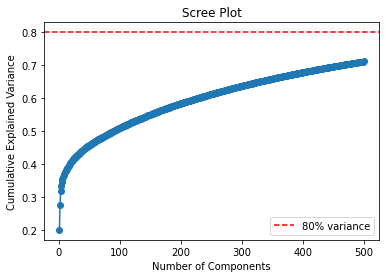

In [ ]:
#plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
#plt.axhline(y=0.80, color='r', linestyle='--', label="80% variance")
#plt.xlabel("Number of Components")
#plt.ylabel("Cumulative Explained Variance")
#plt.title("Scree Plot")
#plt.legend()
#plt.show()

In [ ]:
#X_test_text_proc_reduced = svd.transform(X_test_text_proc_stem)

### Supplier

In [ ]:
X_train_suppl = np.array(train.puor_id_lfa1_supplier).reshape(-1, 1)
X_test_suppl = np.array(test.puor_id_lfa1_supplier).reshape(-1, 1)
X_train_suppl_one, X_test_suppl_one, cats_map_suppl = encoding_categorical_features(
    X_train=X_train_suppl, X_test=X_test_suppl, min_frq=10
)

Number of features:14649
First five features:['SAPECCFE3_0000010001' 'SAPECCFE3_0000010007' 'SAPECCFE3_0000010009'
 'SAPECCFE3_0000010011' 'SAPECCFE3_0000010018']
Infrequent categories: 11920
First five entries: ['SAPECCFE3_0000010009' 'SAPECCFE3_0000010011' 'SAPECCFE3_0000010018'
 'SAPECCFE3_0000010020' 'SAPECCFE3_0000010045']
Retained features (# Features - Infrequent features): 2729


C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_suppl_one.shape

(311220, 2729)

In [ ]:
X_test_suppl_one.shape

(61282, 2729)

### Purchasing Organization

In [ ]:
X_train_porg = np.array(train.puor_id_pror_purchasing_org).reshape(-1, 1)
X_test_porg = np.array(test.puor_id_pror_purchasing_org).reshape(-1, 1)
X_train_porg_one, X_test_porg_one, cats_map_porg = encoding_categorical_features(
    X_train=X_train_porg, X_test=X_test_porg, min_frq=10
)

Number of features:407
First five features:['SAPECCFE3_2A09' 'SAPECCFE3_2A10' 'SAPECCFE3_AE09' 'SAPECCFE3_AE29'
 'SAPECCFE3_AE33']
Infrequent categories: 89
First five entries: ['SAPECCFE3_AE09' 'SAPECCFE3_AE29' 'SAPECCFE3_AE38' 'SAPECCFE3_AE40'
 'SAPECCFE3_AR08']
Retained features (# Features - Infrequent features): 318


C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_porg_one.shape

(311220, 318)

In [ ]:
X_test_porg_one.shape

(61282, 318)

### Company

In [ ]:
X_train_comp = np.array(train.puor_id_t001_company).reshape(-1, 1)
X_test_comp = np.array(test.puor_id_t001_company).reshape(-1, 1)
X_train_comp_one, X_test_comp_one, cats_map_comp = encoding_categorical_features(
    X_train=X_train_comp, X_test=X_test_comp, min_frq=20
)

Number of features:90
First five features:['SAPECCFE3_10ES' 'SAPECCFE3_10RO' 'SAPECCFE3_10SE' 'SAPECCFE3_11CN'
 'SAPECCFE3_11SE']
Infrequent categories: 7
First five entries: ['SAPECCFE3_AE10' 'SAPECCFE3_AE20' 'SAPECCFE3_BE30' 'SAPECCFE3_LU35'
 'SAPECCFE3_VN30']
Retained features (# Features - Infrequent features): 83


### Purchasing Group

In [ ]:
X_train_pgrp = np.array(train.puor_id_prgp_purchasing_group).reshape(-1, 1)
X_test_pgrp = np.array(test.puor_id_prgp_purchasing_group).reshape(-1, 1)
X_train_pgrp_one, X_test_pgrp_one, cats_map_prgp = encoding_categorical_features(
    X_train=X_train_pgrp, X_test=X_test_pgrp, min_frq=10
)

Number of features:1272
First five features:['SAPECCFE3_000' 'SAPECCFE3_004' 'SAPECCFE3_100' 'SAPECCFE3_101'
 'SAPECCFE3_103']
Infrequent categories: 574
First five entries: ['SAPECCFE3_000' 'SAPECCFE3_004' 'SAPECCFE3_100' 'SAPECCFE3_101'
 'SAPECCFE3_10C']
Retained features (# Features - Infrequent features): 698


C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
y_train = train.puor_ds_level1_new
y_test = test.puor_ds_level1_new

## Modeling

### Predicting Level 1

Let's use just text features to compare tf-idf and word2vec

TF-IDF only

In [ ]:
print("TF-IDF (Lemmatization)")
# weights = {"SUPPLY CHAIN": 0.43, "TECHNICAL PROCUREMENT": 0.75, "GENERAL PROCUREMENT": 0.82}
tree, y_predictions, y_gold_labels = model(
    DecisionTreeClassifier, X_tr=X_train_text_proc_lem, y_tr=y_train, X_ts=X_test_text_proc_lem, y_ts=y_test, cls_wght='balanced'
)

TF-IDF (Lemmatization)
Accuracy on training set: 0.898
Accuracy on test set: 0.714
Accuracy on test set by a DUMMY CLASSIFIER: 0.209
Classification Report for Test Set
                       precision    recall  f1-score   support

  GENERAL PROCUREMENT       0.83      0.74      0.78     33866
         SUPPLY CHAIN       0.03      0.56      0.06       411
TECHNICAL PROCUREMENT       0.77      0.69      0.73     27005

             accuracy                           0.71     61282
            macro avg       0.54      0.66      0.52     61282
         weighted avg       0.80      0.71      0.75     61282

Classification Report for Training Set
                       precision    recall  f1-score   support

  GENERAL PROCUREMENT       0.74      0.84      0.79     56122
         SUPPLY CHAIN       0.92      0.92      0.92    177994
TECHNICAL PROCUREMENT       0.97      0.89      0.93     77104

             accuracy                           0.90    311220
            macro avg       0.88

In [ ]:
print("TF-IDF (Stemmatization)")
# weights = {"SUPPLY CHAIN": 0.43, "TECHNICAL PROCUREMENT": 0.75, "GENERAL PROCUREMENT": 0.82}
tree, y_predictions, y_gold_labels = model(
    DecisionTreeClassifier, X_tr=X_train_text_proc_stem, y_tr=y_train, X_ts=X_test_text_proc_stem, y_ts=y_test, cls_wght='balanced'
)

TF-IDF (Stemmatization)
Accuracy on training set: 0.900
Accuracy on test set: 0.732
Accuracy on test set by a DUMMY CLASSIFIER: 0.216
Classification Report for Test Set
                       precision    recall  f1-score   support

  GENERAL PROCUREMENT       0.84      0.76      0.80     33866
         SUPPLY CHAIN       0.04      0.60      0.07       411
TECHNICAL PROCUREMENT       0.78      0.70      0.74     27005

             accuracy                           0.73     61282
            macro avg       0.55      0.69      0.54     61282
         weighted avg       0.81      0.73      0.77     61282

Classification Report for Training Set
                       precision    recall  f1-score   support

  GENERAL PROCUREMENT       0.74      0.85      0.79     56122
         SUPPLY CHAIN       0.93      0.92      0.92    177994
TECHNICAL PROCUREMENT       0.97      0.90      0.94     77104

             accuracy                           0.90    311220
            macro avg       0.8

TF-IDF (Stemmatization) with Latent Semantic Analysis

In [ ]:
#print(f"TF-IDF (Stemmatization) with Latent Semantic Analysis (Number of components retained: {len(svd.components_)})")
#tree, y_predictions, y_gold_labels = model(
#    DecisionTreeClassifier, X_tr=X_train_text_proc_reduced, y_tr=y_train, X_ts=X_test_text_proc_reduced, y_ts=y_test, cls_wght='balanced'
#)

Using Word2Vec

In [ ]:
print("Word2Vec")
#tree, y_predictions, y_gold_labels = model(
#    DecisionTreeClassifier, X_tr=X_train_word2vec, y_tr=y_train, X_ts=X_test_word2vec, y_ts=y_test, cls_wght='balanced'
#)

Word2Vec


I retain the TF-IDF Model with stemmatization as it provides the greatest performance and it is faster since it uses sparse vectors. 

In the following I concatenate the other features e.g. suppliers, purchasing organizations etc.

### Train and Test Set Engineering

In [ ]:
X_train = sp.sparse.hstack(
    [X_train_text_proc_stem, X_train_suppl_one, X_train_porg_one, X_train_comp_one, X_train_pgrp_one]
)
# X_train = sp.sparse.hstack([X_train_text_proc,X_train_suppl_one ])

X_test = sp.sparse.hstack(
    [X_test_text_proc_stem, X_test_suppl_one, X_test_porg_one, X_test_comp_one, X_test_pgrp_one]
)
# X_test = sp.sparse.hstack([X_test_text_proc,X_test_suppl_one])

In [ ]:
dicts = [cats_map_text, cats_map_suppl,cats_map_porg,cats_map_comp, cats_map_prgp]  # List of dictionaries
categories_mapping = {}
counter = 0  # Start progressive index

for d in dicts:
    for value in d.values():
        categories_mapping[counter] = value
        counter += 1

len(categories_mapping)

8112

In [ ]:
X_train.shape

(311220, 8112)

In [ ]:
tree, y_predictions, y_gold_labels = model(
    DecisionTreeClassifier, X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, cls_wght='balanced'
)

Accuracy on training set: 0.946
Accuracy on test set: 0.962
Accuracy on test set by a DUMMY CLASSIFIER: 0.211
Classification Report for Test Set
                       precision    recall  f1-score   support

  GENERAL PROCUREMENT       0.97      0.97      0.97     33866
         SUPPLY CHAIN       0.57      0.63      0.60       411
TECHNICAL PROCUREMENT       0.96      0.96      0.96     27005

             accuracy                           0.96     61282
            macro avg       0.83      0.85      0.84     61282
         weighted avg       0.96      0.96      0.96     61282

Classification Report for Training Set
                       precision    recall  f1-score   support

  GENERAL PROCUREMENT       0.80      0.94      0.86     56122
         SUPPLY CHAIN       0.98      0.93      0.95    177994
TECHNICAL PROCUREMENT       1.00      1.00      1.00     77104

             accuracy                           0.95    311220
            macro avg       0.93      0.95      0.94   

In [ ]:
categories_mapping

{0: 'nutella',
 1: 'social',
 2: 'retain',
 3: 'aug',
 4: 'inv',
 5: 'transport',
 6: 'riodejanei',
 7: 'transport riodejanei',
 8: 'kinder',
 9: 'surpris',
 10: 'shelf',
 11: 'freight',
 12: 'product',
 13: 'bucket',
 14: 'elitebook',
 15: 'rocher',
 16: 'tvc',
 17: 'high',
 18: 'cabinet',
 19: 'door',
 20: 'refurbish',
 21: 'vision',
 22: 'review',
 23: 'ksaison',
 24: 'guarulho',
 25: 'jundiai',
 26: 'transport guarulho',
 27: 'guarulho jundiai',
 28: 'suzano',
 29: 'guarulho suzano',
 30: 'brasilia',
 31: 'transport brasilia',
 32: 'digit',
 33: 'septemb',
 34: 'post',
 35: 'roc',
 36: 'post product',
 37: 'test',
 38: 'kit',
 39: 'stick',
 40: 'piracicaba',
 41: 'guarulho piracicaba',
 42: 'saopaulo',
 43: 'guarulho saopaulo',
 44: 'mtto',
 45: 'polici',
 46: 'payment',
 47: 'sam',
 48: 'portal',
 49: 'flower',
 50: 'lock',
 51: 'lyreco',
 52: 'squar',
 53: 'oct',
 54: 'clean',
 55: 'master',
 56: 'move',
 57: 'servic',
 58: 'leaflet',
 59: 'version',
 60: 'nielsen',
 61: 'report'

In [ ]:
features_imp = tree.feature_importances_
sort_idx = np.argsort(features_imp)[::-1]

In [ ]:
for idx in sort_idx[:40]:
    print(f"Feature name: {categories_mapping[idx]}, Feature Importance: {features_imp[idx]}")

Feature name: transport, Feature Importance: 0.27938155439321666
Feature name: SAPECCFE3_LU19, Feature Importance: 0.05756008382461888
Feature name: SAPECCFE3_ITT3, Feature Importance: 0.05279788770271939
Feature name: SAPECCFE3_ZA19, Feature Importance: 0.05110562626725612
Feature name: SAPECCFE3_US29, Feature Importance: 0.03849044664827288
Feature name: SAPECCFE3_AU10, Feature Importance: 0.03459424927521124
Feature name: SAPECCFE3_BE20, Feature Importance: 0.030565500321101634
Feature name: SAPECCFE3_NL09, Feature Importance: 0.030245107101568053
Feature name: SAPECCFE3_BR10, Feature Importance: 0.019114009705624532
Feature name: SAPECCFE3_O19, Feature Importance: 0.018494095366372764
Feature name: SAPECCFE3_CH09, Feature Importance: 0.01675947868768751
Feature name: SAPECCFE3_ES10, Feature Importance: 0.015958831699142816
Feature name: SAPECCFE3_MX03, Feature Importance: 0.015721527562778018
Feature name: SAPECCFE3_BG10, Feature Importance: 0.015224407409163717
Feature name: SAPEC

In [ ]:
# forest = RandomForestClassifier(random_state=RANDOM_STATE)
# forest.fit(X_train, y_train)
# print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
# print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

In [ ]:
# for i in np.arange(10,100, 10):
#     print(i)
#     forest = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=i)
#     forest.fit(X_train, y_train)
#
#     print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
#     print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

In [ ]:
# gbrt = GradientBoostingClassifier(random_state=RANDOM_STATE)
# gbrt.fit(X_train, y_train)
#
# print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
# print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

### Integrating Level1 and Predicting Level2

In [ ]:
X_train1, X_test1 = integrating_prev_lev_predict_next_lev(
    X_train, X_test, level="puor_ds_level1_new", model=tree
)
y_train1 = train.puor_ds_level2_new
y_test1 = test.puor_ds_level2_new

Number of features:3
First five features:['GENERAL PROCUREMENT' 'SUPPLY CHAIN' 'TECHNICAL PROCUREMENT']


In [ ]:
tree1, y_predictions1, y_gold_labels1 = model(
    DecisionTreeClassifier, X_tr=X_train1, y_tr=y_train1, X_ts=X_test1, y_ts=y_test1, cls_wght='balanced'
)

Accuracy on training set: 0.942
Accuracy on test set: 0.716
Accuracy on test set by a DUMMY CLASSIFIER: 0.069
Classification Report for Test Set


C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                      AUTOMATION & MRO       0.74      0.70      0.72     13038
CUSTOM BROKERAGE & FORWARDING AGENCIES       0.51      0.93      0.66       117
                                ENERGY       0.16      0.76      0.26       145
      ENERGY AND UTILITIES FOR OFFICES       0.74      0.93      0.82        15
           INFRASTRUCTURE & INDUSTRIAL       0.65      0.54      0.59      9292
           IT - INFORMATION TECHNOLOGY       0.36      0.92      0.52       246
                    MARKETING SERVICES       0.97      0.83      0.89     14748
                              MOBILITY       0.60      0.91      0.72      1439
                          OTHER NON GP       0.00      0.00      0.00         0
                   PALLETTS PURCHASING       0.70      0.30      0.42        23
                 PALLETTS RENT & LEASE       0.96      0.98      0.97        54
                       PEOPLE SERVICES 

In [ ]:
X_test_lvl2_pred = tree1.predict(X_test1).reshape(-1, 1)
n = 0
range = np.arange(130, 140)
for i in range + 1:
    print(i)
    print(f"PO Line: {test.puor_id_order_line.iloc[i]}")
    if X_test_lvl2_pred[i][0] == test.puor_ds_level2_new.iloc[i]:
        print("vvv CORRECT PREDICTION vvv")
        n += 1
    else:
        print("xxx NOT CORRECT PREDICTION xxx")

    print(f"Prediction is {X_test_lvl2_pred[i][0]}")
    print(f"Truth is {test.puor_ds_level2_new.iloc[i]}")
    print("------")
print(f"Number of correct cases {n} out of {len(range)}")

### Integrating Level2 and Predicting Level3

In [ ]:
X_train2, X_test2 = integrating_prev_lev_predict_next_lev(
    X_train1, X_test1, level="puor_ds_level2_new", model=tree1
)
y_train2 = train.puor_ds_level3_new
y_test2 = test.puor_ds_level3_new

Number of features:20
First five features:['AUTOMATION & MRO' 'CUSTOM BROKERAGE & FORWARDING AGENCIES' 'ENERGY'
 'ENERGY AND UTILITIES FOR OFFICES' 'INFRASTRUCTURE & INDUSTRIAL']


In [ ]:
tree2, y_predictions2, y_gold_labels2 = model(
    DecisionTreeClassifier, X_tr=X_train2, y_tr=y_train2, X_ts=X_test2, y_ts=y_test2, cls_wght='balanced'
)

Accuracy on training set: 0.908
Accuracy on test set: 0.662
Accuracy on test set by a DUMMY CLASSIFIER: 0.033
Classification Report for Test Set


C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                           precision    recall  f1-score   support

                                      ADMINISTRATION COST       0.00      0.00      0.00         0
                                  ADMINISTRATIVE SERVICES       0.47      0.85      0.61        52
                                B&U PROFESSIONAL SERVICES       0.11      0.45      0.17       329
                                           CERTIFICATIONS       0.02      0.50      0.03        26
                                                 CLEANING       0.83      0.37      0.51      1876
                                         CLEANING (LOCAL)       0.08      1.00      0.14        17
                         COMMERCIAL QUALITY AND FRESHNESS       0.91      0.68      0.78        44
                                     CONSULTANCY SERVICES       0.50      0.54      0.52       125
                               CONSUMER RESEARCH (AD-HOC)       0.28      0.84      0.41       237
         

In [ ]:
X_test_lvl3_pred = tree2.predict(X_test2).reshape(-1, 1)
n = 0
range = np.arange(130, 140)
for i in range + 1:
    print(i)
    print(f"PO Line: {test.puor_id_order_line.iloc[i]}")
    if X_test_lvl3_pred[i][0] == test.puor_ds_level3_new.iloc[i]:
        print("vvv CORRECT PREDICTION vvv")
        n += 1
    else:
        print("xxx NOT CORRECT PREDICTION xxx")

    print(f"Prediction is {X_test_lvl3_pred[i][0]}")
    print(f"Truth is {test.puor_ds_level3_new.iloc[i]}")
    print("------")
print(f"Number of correct cases {n} out of {len(range)}")

### Integrating Level3 and Predicting Level4

In [ ]:
X_train3, X_test3 = integrating_prev_lev_predict_next_lev(
    X_train2, X_test2, level="puor_ds_level3_new", model=tree2
)
y_train3 = train.puor_ds_level4_new
y_test3 = test.puor_ds_level4_new

Number of features:104
First five features:['ADMINISTRATION COST' 'ADMINISTRATIVE SERVICES' 'AIR FREIGHT TRANSPORT'
 'B&U PROFESSIONAL SERVICES' 'BONUS / MALUS\xa0(WAREHOUSING)']


In [ ]:
tree3, y_predictions3, y_gold_labels3 = model(
    DecisionTreeClassifier, X_tr=X_train3, y_tr=y_train3, X_ts=X_test3, y_ts=y_test3, cls_wght='balanced'
)

Accuracy on training set: 0.887
Accuracy on test set: 0.641
Accuracy on test set by a DUMMY CLASSIFIER: 0.005
Classification Report for Test Set


C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

                                                              precision    recall  f1-score   support

                                            1/4 Wood Pallets       1.00      1.00      1.00        14
                  1st Level Support Outsourcing Applications       0.49      0.88      0.63        26
                    1st Level Support Outsourcing Technology       0.00      0.00      0.00        11
                    2nd Level Support Outsourcing Technology       0.00      0.00      0.00        37
       Ad hoc reports/ analysis performed on Retail Panel DB       0.33      0.15      0.21        13
       Ad hoc reports/analysis on syndicated data (excl RMS)       0.28      0.42      0.33        12
         Additional Services and Costs for Real Estate Lease       0.44      0.92      0.59        26
                            Administrative Costs Warehousing       0.00      0.00      0.00         0
                        Application Perpetual Licenses CAPEX       1.00      1.00

In [ ]:
X_test_lvl4_pred = tree3.predict(X_test3).reshape(-1, 1)
n = 0
range = np.arange(130, 140)
for i in range + 1:
    print(i)
    print(f"PO Line: {test.puor_id_order_line.iloc[i]}")
    if X_test_lvl4_pred[i][0] == test.puor_ds_level4_new.iloc[i]:
        print("vvv CORRECT PREDICTION vvv")
        n += 1
    else:
        print("xxx NOT CORRECT PREDICTION xxx")

    print(f"Prediction is {X_test_lvl4_pred[i][0]}")
    print(f"Truth is {test.puor_ds_level4_new.iloc[i]}")
    print("------")
print(f"Number of correct cases {n} out of {len(range)}")